<a href="https://colab.research.google.com/github/JasperAD11/Sentiment-Across-Signals-Neural-Networks-vs.-LLMs/blob/main/project_ATPA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**TO DO**:
  1. Compute results for other models (change parameters) and compare.
  2. Code doesn't run for the second model

**Doubts**:
  1. what if the same word appears 2x in the same review/newswire, is that explicit in the tensor?

# Project: Part 1

## Functions and libraries needed

### Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, pathlib, shutil, random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, TextVectorization, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
# Set a fixed random seed value
SEED = 42

np.random.seed(SEED)
tf.random.set_seed(SEED)

### Vectorizing text inputs

In [3]:
# Vectorizing text
text_vectorization = TextVectorization(
    max_tokens=20000,
    output_mode="tf_idf",
)

### Pre-trained embedding layer - GloVe

In [4]:
# Run only once
# !wget http://nlp.stanford.edu/data/glove.6B.zip

--2025-04-29 16:01:27--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-04-29 16:01:27--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-04-29 16:01:28--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [5]:
# Run only once
# !unzip -q glove.6B.zip

In [6]:
# Loading pre-trained word embedding (GloVe)   PAGE 333 BOOK
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
  for line in f:
    word, coefs = line.split(maxsplit=1)
    coefs = np.fromstring(coefs, "f", sep=" ")
    embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


In [7]:
embedding_dim = 100
max_tokens = 20000

vocabulary = text_vectorization.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))

embedding_matrix = np.zeros((max_tokens, embedding_dim))
for word, i in word_index.items():
  if i < max_tokens:
    embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [8]:
embedding_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
    )

## Model 1: Binary sentiment classification

### Dataset


In [9]:
# Run only once
# !curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
# !tar -xf aclImdb_v1.tar.gz
# !rm -r aclImdb/train/unsup

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  60.0M      0  0:00:01  0:00:01 --:--:-- 60.0M


In [10]:
base_dir = pathlib.Path("aclImdb")

val_dir = base_dir / "val"
train_dir = base_dir / "train"

for category in ("neg", "pos"):
  os.makedirs(val_dir / category)
  files = os.listdir(train_dir / category)
  random.Random(1337).shuffle(files)
  num_val_samples = int(0.2 * len(files))
  val_files = files[-num_val_samples:]
  for fname in val_files:
    shutil.move(train_dir / category / fname,
                val_dir / category / fname)

In [11]:
batch_size = 32

train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size)

val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_size)

test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [12]:
text_only_train_ds = train_ds.map(lambda x, y: x)
text_vectorization.adapt(text_only_train_ds)

binary_1gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

binary_1gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

binary_1gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

### CNN model - first architecture type

In [13]:
# Most simple model

model1_cnn = keras.Sequential([
    layers.Dense(32, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

# Compile the model
model1_cnn.compile(
    optimizer='adam',               # better than rmsprop
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [14]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

history1_cnn = model1_cnn.fit(binary_1gram_train_ds,
                    epochs=20,
                    batch_size=512,
                    validation_data=binary_1gram_val_ds,
                    callbacks=[early_stopping])

model1_cnn.summary()

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.7966 - loss: 0.4406 - val_accuracy: 0.8912 - val_loss: 0.2850
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9499 - loss: 0.1365 - val_accuracy: 0.8888 - val_loss: 0.3821
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.9849 - loss: 0.0446 - val_accuracy: 0.8748 - val_loss: 0.5623
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9945 - loss: 0.0203 - val_accuracy: 0.8694 - val_loss: 0.6269


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │       640,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,921,733 (7.33 MB)

 Trainable params: 640,577 (2.44 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,281,156 (4.89 MB)

With model1_cnn we have around 89% val_accuracy.

In [15]:
# Functional model (from the book)
def get_model(max_tokens=20000, hidden_dim=16):
  inputs = keras.Input(shape=(max_tokens,))
  x = layers.Dense(hidden_dim, activation="relu")(inputs)
  x = layers.Dropout(0.5)(x)
  outputs = layers.Dense(1, activation="sigmoid")(x)

  model = keras.Model(inputs, outputs)

  model.compile(optimizer="rmsprop",
                loss="binary_crossentropy",
                metrics=["accuracy"])
  return model

In [16]:
model2_cnn = get_model()

callbacks = [
    keras.callbacks.ModelCheckpoint("binary_1gram.keras",
                                    save_best_only=True)
    ]

history2_cnn = model2_cnn.fit(binary_1gram_train_ds.cache(),
                              validation_data=binary_1gram_val_ds.cache(),
                              epochs=10,
                              callbacks=callbacks)

model2_cnn.summary()

model2_cnn = keras.models.load_model("binary_1gram.keras")

print(f"Test acc: {model2_cnn.evaluate(binary_1gram_test_ds)[1]:.3f}")

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.7521 - loss: 0.5106 - val_accuracy: 0.8984 - val_loss: 0.2848
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9010 - loss: 0.2764 - val_accuracy: 0.8956 - val_loss: 0.3013
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9212 - loss: 0.2250 - val_accuracy: 0.8940 - val_loss: 0.3177
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9305 - loss: 0.2103 - val_accuracy: 0.8952 - val_loss: 0.3361
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9384 - loss: 0.1907 - val_accuracy: 0.8958 - val_loss: 0.3445
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9412 - loss: 0.1754 - val_accuracy: 0.8916 - val_loss: 0.3597
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9436 - loss: 0.1702 - val_accuracy: 0.8828 - val_loss: 0.3830
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9467 - loss: 0.1619 - val_accuracy: 0

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 20000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │       320,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 640,068 (2.44 MB)

 Trainable params: 320,033 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 320,035 (1.22 MB)

782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8808 - loss: 0.3154
Test acc: 0.882


With model2_cnn we have around 90% val_accuracy.

#### Plotting:

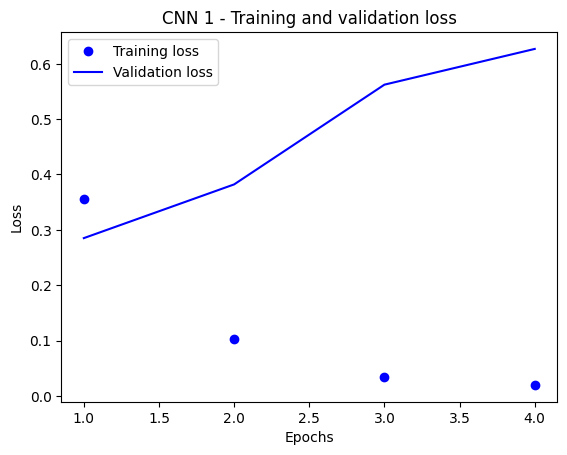

In [17]:
# Loss
history_dict = history1_cnn.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("CNN 1 - Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

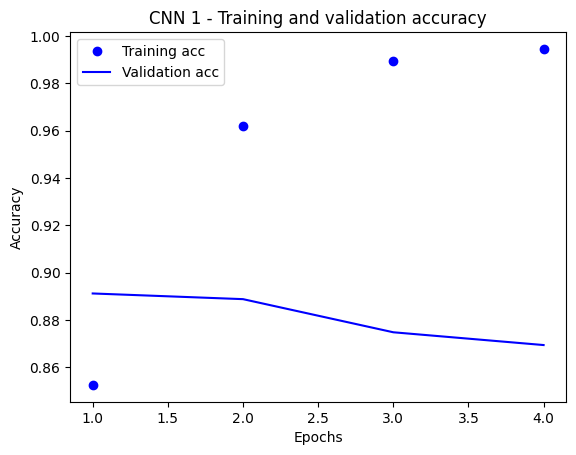

In [18]:
# Accuracy
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("CNN 1 - Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

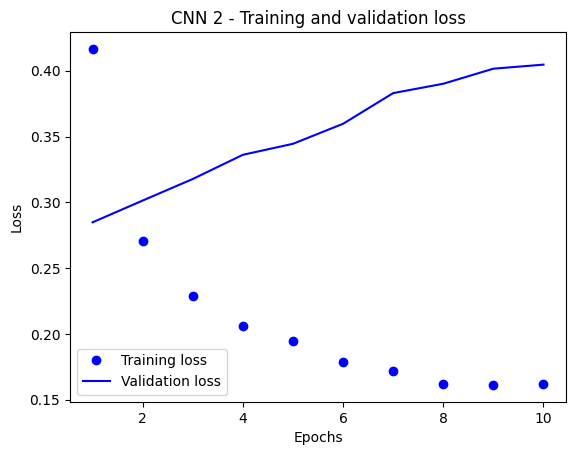

In [19]:
# Loss
history_dict = history2_cnn.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("CNN 2 - Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

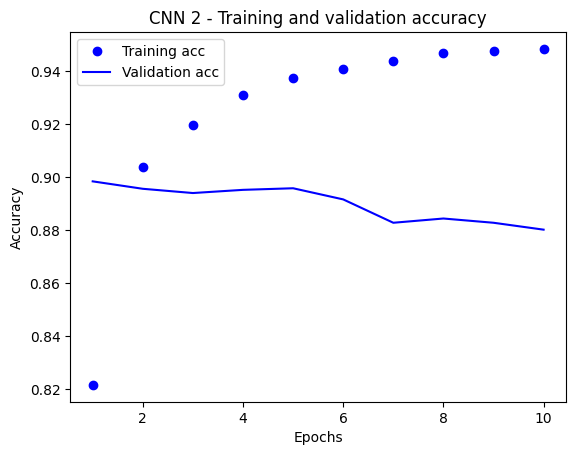

In [20]:
# Accuracy
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("CNN 2 - Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### LSTM model - second architecture

In [23]:
# Functional LSTM with embedding (from book)
inputs = keras.Input(shape=(None,), dtype="int64")

embedded = embedding_layer(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model1_lstm = keras.Model(inputs, outputs)
model1_lstm.compile(optimizer="rmsprop",
                    loss="binary_crossentropy",
                    metrics=["accuracy"])

callbacks = [keras.callbacks.ModelCheckpoint("embeddings_bidir_gru.keras", save_best_only=True)]

In [24]:

model1_lstm.fit(binary_1gram_train_ds,
                validation_data=binary_1gram_val_ds,
                epochs=10,
                callbacks=callbacks)

model1_lstm.summary()

model1_lstm = keras.models.load_model("embeddings_bidir_gru.keras")

print(f"Test acc: {model1_lstm.evaluate(binary_1gram_test_ds)[1]:.3f}")

Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node functional_2_1/bidirectional_2_1/forward_lstm_2_1/Assert/Assert defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-24-e7ed85e07f86>", line 1, in <cell line: 0>

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 113, in one_step_on_data

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 57, in train_step

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py", line 908, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py", line 182, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py", line 637, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py", line 908, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py", line 218, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py", line 908, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/lstm.py", line 584, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py", line 402, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/lstm.py", line 551, in inner_loop

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/rnn.py", line 841, in lstm

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/rnn.py", line 874, in _cudnn_lstm

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/rnn.py", line 557, in _assert_valid_mask

assertion failed: [You are passing a RNN mask that does not correspond to right-padded sequences, while using cuDNN, which is not supported. With cuDNN, RNN masks can only be used for right-padding, e.g. `[[True, True, False, False]]` would be a valid mask, but any mask that isn\'t just contiguous `True`\'s on the left and contiguous `False`\'s on the right would be invalid. You can pass `use_cudnn=False` to your RNN layer to stop using cuDNN (this may be slower).]
	 [[{{node functional_2_1/bidirectional_2_1/forward_lstm_2_1/Assert/Assert}}]] [Op:__inference_multi_step_on_iterator_320364]

In [ ]:
history = model_lstm.fit(partial_x_train,                       # history is an 'History' object
                          partial_y_train,
                          epochs=20,
                          batch_size=32,
                          validation_data=(x_val, y_val))

In [ ]:
model_lstm.summary()

In [ ]:
# History objects have a member 'history' that is a dict
history_dict = history.history

history_dict.keys()
# history_dict.values()

#### Plotting:

In [ ]:
# Loss
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Accuracy
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Final model

Retraining the model in all the train data and evaluation in test data.
After that we are computing the results.

In [ ]:
# Train the model
history = model_lstm.fit(
    x_train, y_train,
    batch_size=32,
    epochs=10,
    validation_split=0.2,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=2),
        keras.callbacks.ModelCheckpoint('best_lstm_model.h5', save_best_only=True)
    ]
)

In [ ]:
model = keras.Sequential([
    ])

model.compile(optimizer=,
              loss=,
              metrics=)

model.fit(x_train, y_train, epochs=4, batch_size=512)

results = model.evaluate(x_test, y_test)

results

Making predictions:

In [ ]:
model.predict(x_test)

### Can we improve the model? How?

We experiment different architecture:
1. Add another layer / Take out one layer.
2. Increse/Decrease perceptrons inside layers (usualy factors of 8: 32, 64, 128).
3. Try 'mse' for loss function.
4. Try 'tanh' for activation function.

In [ ]:
# Model that uses pre trained embedding (book)
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = embedding_layer(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
loss="binary_crossentropy",
metrics=["accuracy"])
model.summary()
callbacks = [
keras.callbacks.ModelCheckpoint("glove_embeddings_sequence_model.keras",
save_best_only=True)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=10,
callbacks=callbacks)
model = keras.models.load_model("glove_embeddings_sequence_model.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

##  Model 2: Multi-class emotion detection

In [ ]:
from tensorflow.keras.datasets import reuters   # Dataset with news labeled with a topic

### Dataset

(using reuters dataset inside tensorflow.keras.datasets)

In [ ]:
df_1= pd.read_csv("goemotions_1.csv")
df_2= pd.read_csv("goemotions_2.csv")
df_3= pd.read_csv("goemotions_3.csv")

In [ ]:
(train_data, train_labels),(test_data, test_labels) = reuters.load_data(num_words = 100000)
# again we are only interested in the TOP10000 words

#### not necessary

In [ ]:
len(train_data)

In [ ]:
len(test_data)

In [ ]:
len(train_labels)

Note that the format of the data is the same as in the previous case, where each piece of news is encode into a list of integers, being each of them correspondent to a word.

Extra: decoding back to word (same as in imdb case)

In [ ]:
word_index = reuters.get_word_index()    # dict that maps each word to its code number

reverse_word_index = dict(            # dict inverting value and key (number to word)
    [(value, key) for (key, value) in word_index.items()])

# Decoding train_data[0]
decoded_newswire = " ".join(
    [reverse_word_index.get(i - 3, "?") for i in train_data[0]])

decoded_newswire

### Turning lists into tensors (same code as before)

In [ ]:
# Dont understand this error
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [ ]:
# Vectorizing labels (diferent than in the previous case because there are more than 2 labels)

def to_one_hot(labels, dimension=46):
  results = np.zeros((len(labels), dimension))
  for i, label in enumerate(labels):
    results[i, label] = 1.
  return results

# this yields a matrix with 46 dimensions(columns),
# where all values in a row are 0 except in the column with the number of the correct label

y_train = to_one_hot(train_labels)
y_test = to_one_hot(test_labels)

In [ ]:
# There is all this built in way to do it
# from tensorflow.keras.utils import to_categorical
# y_train = to_categorical(train_labels)
# y_test = to_categorical(test_labels)

### CNN model

In [ ]:
max_features = 10000   # Define maximum number of words to consider in the vocabulary
maxlen = 500           # Define sequence length (truncate or pad sequences to this length)
embedding_dim = 128    # Embedding dimension

# Create the model
model_cnn = keras.Sequential([
    # Embedding layer to convert word indices to dense vectors
    layers.Embedding(input_dim=max_features, output_dim=embedding_dim, input_length=maxlen),

    # 1D CNN layers for extracting n-gram features
    layers.Conv1D(filters=128, kernel_size=5, activation='relu', padding='same'),
    layers.MaxPooling1D(pool_size=5),
    layers.Conv1D(filters=128, kernel_size=5, activation='relu', padding='same'),
    layers.MaxPooling1D(pool_size=5),
    layers.Conv1D(filters=128, kernel_size=5, activation='relu', padding='same'),
    layers.GlobalMaxPooling1D(),

    # Dense layers for classification
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Add dropout to reduce overfitting
    layers.Dense(1, activation='sigmoid')  # Binary classification output
])

# Compile the model
model_cnn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# model.compile(optimizer="rmsprop",            # choosing optimizer
#               loss="binary_crossentropy",     # choosing loss function
#               metrics=["accuracy"])

Let's compute validation datasets.

In [ ]:
# Splitting train into partial_train and validation
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

Let's now train the model

In [ ]:
history = model_cnn.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

#### Plotting

In [ ]:
# Loss
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Accuracy
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Transformer model

In [ ]:
# Define parameters
max_features = 10000  # Size of vocabulary
maxlen = 500  # Max sequence length
embedding_dim = 128  # Embedding dimension

# Transformer block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Multi-head self-attention
    attention_output = layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=head_size
    )(inputs, inputs)
    attention_output = layers.Dropout(dropout)(attention_output)
    attention_output = layers.LayerNormalization(epsilon=1e-6)(
        inputs + attention_output
    )

    # Feed-forward network
    ffn_output = layers.Dense(ff_dim, activation="relu")(attention_output)
    ffn_output = layers.Dense(inputs.shape[-1])(ffn_output)
    ffn_output = layers.Dropout(dropout)(ffn_output)

    # Second residual connection and layer normalization
    return layers.LayerNormalization(epsilon=1e-6)(
        attention_output + ffn_output
    )

# Define input
inputs = layers.Input(shape=(maxlen,))

# Embedding layer
x = layers.Embedding(max_features, embedding_dim)(inputs)

# Add positional encoding
positions = tf.range(start=0, limit=maxlen, delta=1)
position_embedding = layers.Embedding(
    input_dim=maxlen, output_dim=embedding_dim
)(positions)
x = x + position_embedding

# Apply dropout
x = layers.Dropout(0.1)(x)

# Apply transformer blocks
transformer_blocks = 2
for _ in range(transformer_blocks):
    x = transformer_encoder(x, head_size=64, num_heads=2, ff_dim=128, dropout=0.1)

# Pool across sequence dimension and apply classification layers
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

# Build the model
model_transf = keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model_transf.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
# Train the model
history = model_transf.fit(
    x_train, y_train,
    batch_size=32,
    epochs=5,
    validation_split=0.2,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=2),
        keras.callbacks.ModelCheckpoint('best_transformer_model.h5', save_best_only=True)
    ]
)

In [ ]:
model_transf.summary()

In [ ]:
# Evaluate on test set
test_loss, test_acc = model_transf.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc:.4f}')
"""

### Final model

In [ ]:
# what does this do?
import copy
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hits_array = np.array(test_labels) == np.array(test_labels_copy)
hits_array.mean()

Making predictions:

In [ ]:
predictions = model.predict(x_test)